## Develop approach to examine oxygen-percentiles

Following [Sohail et al. (2022)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020GL091439). **NOTE : need to check how to incorporate compressibility, i.e. use of *in situ* density.**

Ocean volume bounded by surfaces of tracer $\phi$:
$$\mathcal{V}(\phi^*,t) = \iiint_{\phi(x,y,z,t)>\phi^*}dxdydz$$
Tracer content/inventory ($\phi$) bounded by surface of tracer $\phi$:
$$\Phi(\phi^*,t) = \int_0^{\mathcal{V}(\phi^*,t)}\rho(x,y,z,t)\,\phi(x,y,z,t)d\mathcal{V}$$
Bounding tracer value of volume $\mathcal{V}$:
$$\mathcal{V}(\phi^*,t)\Leftrightarrow \phi^{\mathcal{V}}(\mathcal{V},t)$$
Tracer-percentile:
$$p(\phi^*,t) = 100*\mathcal{V}(\phi^*,t)/V_T$$
Tracer inventory as a function of tracer-percentile is:
$$\Phi(p,t) = 0.01V_T\int_0^p\rho(p,t)\phi^p(p,t)dp$$
where $\phi^p(p,t) \equiv \phi^{\mathcal{V}}(\mathcal{V},t)$ at $\mathcal{V}=0.01 \times p \times V_T$

In [84]:
import xarray as xr
import cftime
# import utils.geo as geo
from xhistogram.xarray import histogram
import numpy as np
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

### READ

In [85]:
config_id = 'ESM4_historical_D1'
ds_datadir = '/work/gam/projects/oxygen/data/'
ds_filename = 'ds.'+config_id+'.zarr'
ds = xr.open_zarr(ds_datadir+ds_filename)

### CALCULATE

In [100]:
def calc_histogram(tracer,volume,tracer_bins=None,normalize=True):
    '''
    Derive volumetric histogram for 'tracer' in 'tracer_bins'.
    Returned histogram is normalized by bin width unless normalize=False.
    
    PARAMETERS
        tracer xr.DataArray
        volume xr.DataArray
        tracer_bins None or np.array
        normalize bool
    
    RETURN
        hs xr.DataArray
    '''
    # Get name of tracer
    tracername=tracer.name
    # Derive bins if not specified
    if tracer_bins is None:
        tracer_bins = np.linspace(tracer.min().values,tracer.min().values,50)
    # Get dimensions to sum over (all dimensions and remove 'time')
    histdims = list(tracer.dims)
    histdims.remove('time')
    # Histogram
    hs = histogram(tracer,bins=[tracer_bins],weights=volume,dim=histdims)
    # Assign upper bound as coordinate
    hs = hs.assign_coords({tracername+'_bin':tracer_bins[1:]})
    
    if normalize:
        # Normalize each bin by bin width
        dtracervals = np.diff(tracer_bins)
        dtracer = xr.DataArray(dtracervals,
                               dims=tracername+'_bin',
                               coords={tracername+'_bin':hs[tracername+'_bin']})
        hs = hs/dtracer
    return hs

def invert_and_interpolate_1Dhistogram(hs,percentiles=None):
    '''
    Take cumulative sum of volumetric histogram for a tracer and invert
    to give tracer value as a function of volume percentile.
    
    PARAMETERS
        hs xr.DataArray
        percentiles None or np.array
        
    RETURNS
        tp xr.DataArray
        
    '''
    # Define percentiles if not specified
    if percentiles is None:
        percentiles = np.linspace(1,100,100)
    # Get name of tracer bins
    dim = hs.dims[0]
    # Invert histogram
    inverted = xr.DataArray(hs[dim],dims='percentile',coords={'percentile':hs.values})
    # Find points where percentile coordinate is not monotonically increasing
    diffvals=inverted['percentile'].diff('percentile').values
    diffvals=np.append(1,diffvals) # Append value to start to align difference with latter bin
    diff = xr.DataArray(diffvals,dims=['percentile'],coords={'percentile':inverted['percentile']})
    # Drop points in original histogram where percentile not monotonically increasing
    # (necessary to interpolate onto uniform grid)
    inverted_dropped = inverted.where(diff>0,drop=True)
    # Interpolate onto uniform percentiles
    tp = inverted_dropped.interp({'percentile':percentiles})
    return tp


def calc_tracerpercentile(tracer,volume,tracer_bins=None,percentiles=None,ascending=True):
    '''
    Calculate 'tracer' as a function of volume percentile. This involves binning volume
    in tracer space, deriving the cumulative sum over tracer values, then inverting.
    
    PARAMETERS
        tracer xr.DataArray
        volume xr.DataArray
        tracer_bins None or np.array
        percentiles None or np.array
        ascending bool
            In cumulative volumetric sum, arrange tracer in ascending order.
        
    RETURN
        tp xr.DataArray
        VT xr.DataArray
    '''
    # Get name of tracer
    tracername=tracer.name
    # Derive histogram
    hs = calc_histogram(tracer,volume,tracer_bins=tracer_bins,normalize=True)
    # Sort to ascending or descending
    hs = hs.sortby(tracername+'_bin',ascending=ascending)
    # Cumulative volumetric sum
    VT = hs.sum(tracername+'_bin')
    hs_frac = 100*hs.cumsum(tracername+'_bin')/VT
    print("Loading volumetric histogram.")
    hs_frac.compute()
    # Loop through time, get tracer percentile at each time
    tp = xr.DataArray(dims=['percentile','time'],
                      coords={'percentile':percentiles,'time':hs_frac['time']})
    print("Inverting for tracer percentile at each time.")
    for t in range(len(hs_frac['time'])):
        hsnow = hs_frac.isel(time=t)
        tpnow = invert_and_interpolate_1Dhistogram(hsnow)
        tp[:,t] = tpnow
    return tp,VT

def calc_extensive(tp,VT,prefactor=1):
    '''
    Calculate the extensive tracer quantity based on the tracer percentile.
    For example, if tracer=temperature, calc_extensive can be used to return 
    heat content as a function of tracer percentile.
    
    PARAMETERS
        tp xr.DataArray
        VT float
        prefactor int, float
            Any prefactor for integration, e.g. density or heat capacity
    
    RETURN
        Tp xr.DataArray
    '''
    
    return 0.01*VT*(tp*prefactor).cumsum('percentile')

In [96]:
tracer = ds['o2']
volume = ds['volcello']
tracer_bins = np.linspace(0,0.4,400)
percentiles = np.linspace(1,100,100)
tp,VT = calc_tracerpercentile(tracer = tracer,
                           volume = volume,
                           tracer_bins=tracer_bins,
                           percentiles=percentiles,
                           ascending=True)

Loading volumetric histogram.
Inverting for tracer percentile at each time.


In [101]:
Tp = calc_extensive(tp,VT.mean('time'))

### PLOT

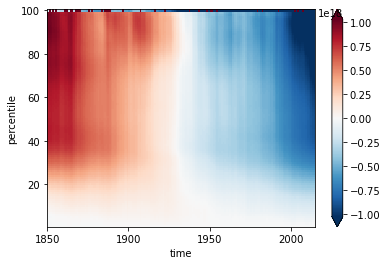

In [104]:
(Tp-Tp.mean('time')).plot(robust=True)

In [80]:
t1 = ['2000','2004']
t2 = ['2010','2014']
t1slice = slice(t1[0]+'-01-01',t1[1]+'-12-31')
t2slice = slice(t2[0]+'-01-01',t2[1]+'-12-31')
t1label = t1[0]+' to '+t1[1]
t2label = t2[0]+' to '+t2[1]
t1color='tab:blue'
t2color='tab:orange'
dt = cftime.datetime(int(t2[1]),12,31)-cftime.datetime(int(t1[1]),12,31)
dt = dt.days*24*60*60

In [81]:
tp_t1 = tp.sel(time=t1slice).mean('time')
tp_t2 = tp.sel(time=t2slice).mean('time')

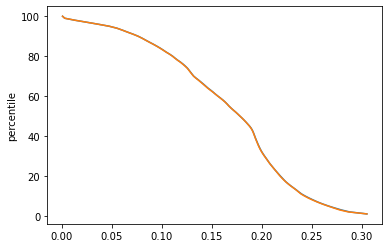

In [82]:
tp_t1.plot(y='percentile')
tp_t2.plot(y='percentile')

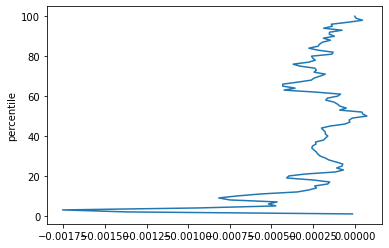

In [83]:
(tp_t2-tp_t1).plot(y='percentile')

In [171]:
(inv_t2-inv_t1).sum('percentile')

<xarray.DataArray 'oxy_bin' ()>
array(-90.15964513)